In [1]:
# Install ipwhois package
!pip install ipwhois

import requests
import pandas as pd
from ipwhois import IPWhois
from ipwhois.exceptions import IPDefinedError
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import re


[notice] A new release of pip is available: 23.1.2 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Fetch Wikipedia edits
def fetch_wikipedia_edits(page_title, limit=1500):
    URL = "https://en.wikipedia.org/w/api.php"
    PARAMS = {
        "action": "query",
        "format": "json",
        "prop": "revisions",
        "titles": page_title,
        "rvprop": "user|timestamp|comment|content",
        "rvlimit": limit
    }
    
    response = requests.get(URL, params=PARAMS)
    data = response.json()
    pages = data['query']['pages']
    
    edits = []
    for page_id, page_data in pages.items():
        if 'revisions' in page_data:
            for rev in page_data['revisions']:
                edits.append({
                    'user': rev.get('user'),
                    'timestamp': rev.get('timestamp'),
                    'comment': rev.get('comment'),
                    'content': rev.get('*')
                })
    
    return edits

In [3]:
# Fetch the edit history for the Zambia page
page_title = "Zambia"
edits = fetch_wikipedia_edits(page_title)
df_edits = pd.DataFrame(edits)

In [4]:
print(df_edits)

                                       user             timestamp  \
0                                   Jbc5050  2024-06-22T18:17:38Z   
1                                   Shangra  2024-06-21T23:29:29Z   
2                                    Kawnhr  2024-06-17T18:52:17Z   
3                            102.212.181.83  2024-06-15T07:42:20Z   
4                            102.212.181.83  2024-06-15T07:41:20Z   
5                                Willthorpe  2024-06-12T16:01:11Z   
6                                 Finetooth  2024-06-10T23:01:51Z   
7                                JoesamuelP  2024-06-10T18:29:18Z   
8                                JoesamuelP  2024-06-10T18:09:11Z   
9                                JoesamuelP  2024-06-10T17:55:30Z   
10                               JoesamuelP  2024-06-10T17:50:53Z   
11                             75.250.82.84  2024-05-31T15:14:01Z   
12                             75.250.82.84  2024-05-31T15:09:25Z   
13                                

In [5]:
# Save the raw dataset
df_edits.to_csv('wikipedia_edits_raw.csv', index=False)

In [6]:
# Clean and preprocess data
def clean_data(df):
    df = df.dropna(subset=['user', 'timestamp'])
    df['comment'] = df['comment'].fillna('')
    df['content'] = df['content'].fillna('')
    
    df['user'] = df['user'].str.lower()
    df['comment'] = df['comment'].str.lower()
    df['content'] = df['content'].str.lower()
    
    return df

df_cleaned = clean_data(df_edits)

In [7]:
# Save the raw dataset
df_cleaned.to_csv('wikipedia_edits_cleaned.csv', index=False)

In [8]:
# Check if a string is an IP address
def is_ip_address(user):
    pattern = re.compile(r"^(?:[0-9]{1,3}\.){3}[0-9]{1,3}$")
    return pattern.match(user) is not None

In [9]:
# Get country from IP address
def get_country_from_ip(ip_address):
    try:
        obj = IPWhois(ip_address)
        results = obj.lookup_rdap()
        return results['network']['country']
    except IPDefinedError:
        return 'Unknown'
    except Exception:
        return 'Unknown'

In [10]:
# Extract country information
def extract_country(df):
    df['country'] = df['user'].apply(lambda x: get_country_from_ip(x) if is_ip_address(x) else 'Unknown')
    return df

df_country = extract_country(df_cleaned)

In [11]:
print(df_country)

                                       user             timestamp  \
0                                   jbc5050  2024-06-22T18:17:38Z   
1                                   shangra  2024-06-21T23:29:29Z   
2                                    kawnhr  2024-06-17T18:52:17Z   
3                            102.212.181.83  2024-06-15T07:42:20Z   
4                            102.212.181.83  2024-06-15T07:41:20Z   
5                                willthorpe  2024-06-12T16:01:11Z   
6                                 finetooth  2024-06-10T23:01:51Z   
7                                joesamuelp  2024-06-10T18:29:18Z   
8                                joesamuelp  2024-06-10T18:09:11Z   
9                                joesamuelp  2024-06-10T17:55:30Z   
10                               joesamuelp  2024-06-10T17:50:53Z   
11                             75.250.82.84  2024-05-31T15:14:01Z   
12                             75.250.82.84  2024-05-31T15:09:25Z   
13                                

In [12]:
# Feature extraction
def extract_features(df):
    df['comment_length'] = df['comment'].apply(len)
    df['content_length'] = df['content'].apply(len)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['hour_of_day'] = df['timestamp'].dt.hour
    
    return df

df_features = extract_features(df_country)

In [13]:
print(df_features)

                                       user                 timestamp  \
0                                   jbc5050 2024-06-22 18:17:38+00:00   
1                                   shangra 2024-06-21 23:29:29+00:00   
2                                    kawnhr 2024-06-17 18:52:17+00:00   
3                            102.212.181.83 2024-06-15 07:42:20+00:00   
4                            102.212.181.83 2024-06-15 07:41:20+00:00   
5                                willthorpe 2024-06-12 16:01:11+00:00   
6                                 finetooth 2024-06-10 23:01:51+00:00   
7                                joesamuelp 2024-06-10 18:29:18+00:00   
8                                joesamuelp 2024-06-10 18:09:11+00:00   
9                                joesamuelp 2024-06-10 17:55:30+00:00   
10                               joesamuelp 2024-06-10 17:50:53+00:00   
11                             75.250.82.84 2024-05-31 15:14:01+00:00   
12                             75.250.82.84 2024-05

In [14]:
# Select features and target
X = df_features[['comment_length', 'content_length', 'hour_of_day']]
y = df_features['country']

In [15]:
# Check data before splitting
print("Features (X) head:")
print(X.head())
print("Target (y) head:")
print(y.head())

print("Missing values in X:")
print(X.isnull().sum())
print("Missing values in y:")
print(y.isnull().sum())

print("Data types of X:")
print(X.dtypes)
print("Data types of y:")
print(y.dtypes)

print("Unique classes in y:")
print(y.unique())

Features (X) head:
   comment_length  content_length  hour_of_day
0              26          151583           18
1               0          151563           23
2             159          151562           18
3              10          151587            7
4              13          151605            7
Target (y) head:
0    Unknown
1    Unknown
2    Unknown
3         ZM
4         ZM
Name: country, dtype: object
Missing values in X:
comment_length    0
content_length    0
hour_of_day       0
dtype: int64
Missing values in y:
4
Data types of X:
comment_length    int64
content_length    int64
hour_of_day       int64
dtype: object
Data types of y:
object
Unique classes in y:
['Unknown' 'ZM' None 'ZA' 'FI' 'GB']


In [16]:
# Handle None values in target variable
y = y.fillna('Unknown')

In [17]:
# Handle None values in features
X = X.fillna(0)

In [18]:
# Check unique classes in target variable again
print("Unique classes in y after handling None values:")
print(y.unique())

Unique classes in y after handling None values:
['Unknown' 'ZM' 'ZA' 'FI' 'GB']


In [19]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=42)

In [20]:
# Check the distribution of the target variable
print("Distribution of y_train:")
print(y_train.value_counts())

Distribution of y_train:
Unknown    18
ZA          1
ZM          1
Name: country, dtype: int64


In [21]:
# Initialize and train the model
try:
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    print("Model training completed successfully.")
except Exception as e:
    print(f"An error occurred during model training: {e}")

Model training completed successfully.


In [22]:
# Predict on the test set
try:
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
except Exception as e:
    print(f"An error occurred during prediction: {e}")

              precision    recall  f1-score   support

          FI       0.00      0.00      0.00         1
          GB       0.00      0.00      0.00         1
     Unknown       0.86      1.00      0.93        25
          ZM       0.00      0.00      0.00         3

    accuracy                           0.83        30
   macro avg       0.22      0.25      0.23        30
weighted avg       0.72      0.83      0.77        30



C:\Users\jonas\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jonas\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jonas\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [24]:
# Evaluate the model on the test set
try:
    y_pred = model.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Accuracy Score:")
    print(accuracy_score(y_test, y_pred))
except Exception as e:
    print(f"An error occurred during prediction: {e}")

Classification Report:
              precision    recall  f1-score   support

          FI       0.00      0.00      0.00         1
          GB       0.00      0.00      0.00         1
     Unknown       0.86      1.00      0.93        25
          ZM       0.00      0.00      0.00         3

    accuracy                           0.83        30
   macro avg       0.22      0.25      0.23        30
weighted avg       0.72      0.83      0.77        30

Confusion Matrix:
[[ 0  0  0  1]
 [ 0  0  1  0]
 [ 0  0 25  0]
 [ 0  0  3  0]]
Accuracy Score:
0.8333333333333334


C:\Users\jonas\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jonas\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jonas\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
# Simulate new data for prediction
new_data = pd.DataFrame({
    'comment_length': [50, 150, 30],
    'content_length': [200, 800, 100],
    'hour_of_day': [12, 4, 19]
})

In [26]:
# Predict the country of origin for new data
try:
    new_predictions = model.predict(new_data)
    print("Predictions for new data:")
    print(new_predictions)
except Exception as e:
    print(f"An error occurred during new data prediction: {e}")

Predictions for new data:
['Unknown' 'Unknown' 'Unknown']


# Hyperparameter Tuning

In [27]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the model
rf = RandomForestClassifier(random_state=42)

# Perform grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

# Train the model with the best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Evaluate the optimized model
y_pred_optimized = best_model.predict(X_test)
print("Optimized Classification Report:")
print(classification_report(y_test, y_pred_optimized))
print("Optimized Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_optimized))
print("Optimized Accuracy Score:")
print(accuracy_score(y_test, y_pred_optimized))

# Predict on New Data with the Optimized Model
try:
    new_predictions_optimized = best_model.predict(new_data)
    print("Predictions for new data with optimized model:")
    print(new_predictions_optimized)
except Exception as e:
    print(f"An error occurred during new data prediction with optimized model: {e}")

Fitting 3 folds for each of 108 candidates, totalling 324 fits


C:\Users\jonas\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-validation score:  0.9047619047619048
Optimized Classification Report:
              precision    recall  f1-score   support

          FI       0.00      0.00      0.00         1
          GB       0.00      0.00      0.00         1
     Unknown       0.86      1.00      0.93        25
          ZM       0.00      0.00      0.00         3

    accuracy                           0.83        30
   macro avg       0.22      0.25      0.23        30
weighted avg       0.72      0.83      0.77        30

Optimized Confusion Matrix:
[[ 0  0  0  1]
 [ 0  0  1  0]
 [ 0  0 25  0]
 [ 0  0  3  0]]
Optimized Accuracy Score:
0.8333333333333334
Predictions for new data with optimized model:
['Unknown' 'Unknown' 'Unknown']


C:\Users\jonas\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jonas\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jonas\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Visualizations

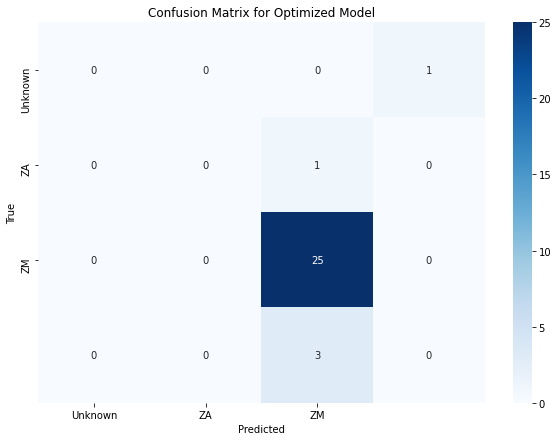

In [28]:
# Confusion matrix visualization
conf_matrix = confusion_matrix(y_test, y_pred_optimized)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Optimized Model')
plt.show()

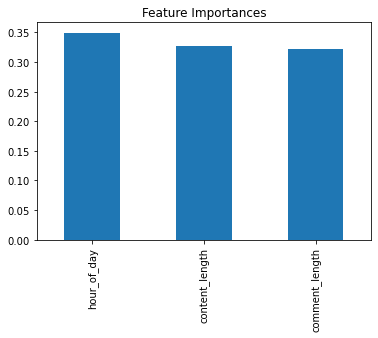

In [29]:
# Feature importance visualization
feature_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importances')
plt.show()

In [30]:
# Predict on New Data with the Optimized Model
new_data = pd.DataFrame({
    'comment_length': [50, 150, 30],
    'content_length': [200, 800, 100],
    'hour_of_day': [12, 4, 19]
})

In [31]:
try:
    new_predictions_optimized = best_model.predict(new_data)
    print("Predictions for new data with optimized model:")
    print(new_predictions_optimized)
except Exception as e:
    print(f"An error occurred during new data prediction with optimized model: {e}")

Predictions for new data with optimized model:
['Unknown' 'Unknown' 'Unknown']
